# Required Library

In [66]:
import os
from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp
from IPython.display import Audio

import librosa
import librosa.display

import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

# Sound to Spectrogram

In [3]:
def create_spectogram(audio_file_name,source_path,save_path): 
  x, sr = librosa.load(source_path+audio_file_name)
  X = librosa.stft(x)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(14, 5))
  librosa.display.specshow(Xdb, sr=sr, y_axis='hz')
  plt.ylabel('')
  plt.axis('off')
  file_name = audio_file_name.replace('.wav','')
  plt.savefig(save_path+file_name+'.jpg', bbox_inches='tight', pad_inches=0)

In [4]:
#Make new folder to relocate image data
!mkdir -p img_dataset/train/{cat,dog}
!mkdir -p img_dataset/test/{cat,dog}

## Train Data

In [ ]:
CAT_TRAIN = '/kaggle/input/audio-cats-and-dogs/cats_dogs/train/cat/' 
for sound in os.listdir(CAT_TRAIN): 
  create_spectogram(sound,CAT_TRAIN,'/kaggle/working/img_dataset/train/cat/')

In [ ]:
DOG_TRAIN = '/kaggle/input/audio-cats-and-dogs/cats_dogs/train/dog/' 
for sound in os.listdir(DOG_TRAIN): 
  create_spectogram(sound,DOG_TRAIN,'/kaggle/working/img_dataset/train/dog/' )

## Test Data

In [ ]:
CAT_TEST = '/kaggle/input/audio-cats-and-dogs/cats_dogs/test/cats/' 
for sound in os.listdir(CAT_TEST): 
  create_spectogram(sound,CAT_TEST,'/kaggle/working/img_dataset/test/cat/')

In [ ]:
DOG_TEST = '/kaggle/input/audio-cats-and-dogs/cats_dogs/test/test/' 
for sound in os.listdir(DOG_TEST): 
  create_spectogram(sound,DOG_TEST,'/kaggle/working/img_dataset/test/dog/' )

# Dataset Generator

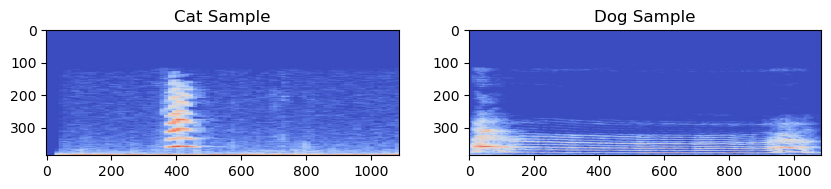

In [38]:
# Take a peek at image data 
sample_cat = '/kaggle/working/img_dataset/test/cat/cat_76.jpg' 
sample_cat = plt.imread(sample_cat)
sample_dog = '/kaggle/working/img_dataset/test/dog/dog_barking_43.jpg'
sample_dog = plt.imread(sample_dog)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,2)) 
ax1.imshow(sample_cat)
ax1.set_title('Cat Sample')
ax2.imshow(sample_dog)
ax2.set_title('Dog Sample')
plt.show()

In [39]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [40]:
train_data = os.path.join('/kaggle/working/img_dataset/train')
val_data = os.path.join('/kaggle/working/img_dataset/test')

In [41]:
train_generator = train_datagen.flow_from_directory(train_data,
                                                    target_size=(250, 250),
                                                    batch_size=30,
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(val_data,
                                                        target_size=(250, 250),
                                                        batch_size=30,
                                                        color_mode='rgb',
                                                        shuffle=True,
                                                        class_mode='binary')

Found 210 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


# CNN model

In [42]:
model = Sequential([Conv2D(40, (5,5), activation='relu', input_shape=(250, 250, 3)),
                    MaxPooling2D(3, 3),
                    
                    Conv2D(80, (5,5), activation='relu'),
                    MaxPooling2D(3, 3),
                    
                    Conv2D(160, (5,5), activation='relu'),
                    MaxPooling2D(3, 3),
                    Flatten(),
                    
                    Dense(400, activation='tanh', kernel_initializer='normal'),
                    Dropout(0.3), # Dropout Layer
                    Dense(200, activation='tanh', kernel_initializer='normal'), # Hidden Layer
                    Dropout(0.3), # Dropout Layer
                    Dense(100, activation='tanh', kernel_initializer='normal'), # Hidden Layer
                    Dense(1, activation='sigmoid')
                    ])

In [43]:
model.compile(optimizer='adamax',
              metrics=['accuracy'],
              loss='binary_crossentropy')

In [51]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.9:
            self.model.stop_training = True


In [52]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    batch_size=64,
                    steps_per_epoch=210//64, # total train data//64
                    validation_steps=67//64, 
                    callbacks=[Callback()]) # total test data//64

Epoch 1/20
3/3 [==============================] - 1s 454ms/step - loss: 0.2169 - accuracy: 0.9333 - val_loss: 0.2162 - val_accuracy: 0.9667


96% accuracy with one epoch

# Prediction Test
0 for cat and 1 for dog

In [61]:
from tensorflow.keras.preprocessing import image
def make_prediction(image_path): 
    # Load Image
    img = image.load_img(image_path, target_size=(250,250,3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) 
    
    # Predict
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10) 
    
    return classes.round()

In [74]:
!mkdir predict_test
DOG_TEST = '/kaggle/input/audio-cats-and-dogs/cats_dogs/test/test/dog_barking_90.wav'
CAT_TEST = '/kaggle/input/audio-cats-and-dogs/cats_dogs/test/cat/cat_110.wav'

mkdir: cannot create directory ‘predict_test’: File exists


## Dog

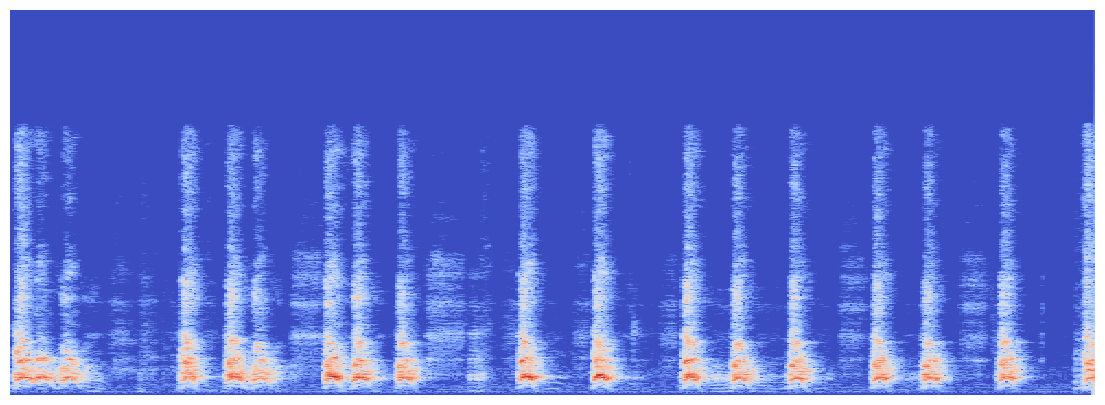

In [78]:
FILE_NAME = 'dog_barking_90.wav'
SOURCE = '/kaggle/input/audio-cats-and-dogs/cats_dogs/test/test/'
create_spectogram(FILE_NAME,SOURCE,'/kaggle/working/predict_test/')

In [79]:
Audio(SOURCE+FILE_NAME)

In [84]:
make_prediction('/kaggle/working/predict_test/dog_barking_90.jpg')

1/1 [==============================] - 0s 24ms/step


array([[1.]], dtype=float32)

## Cat

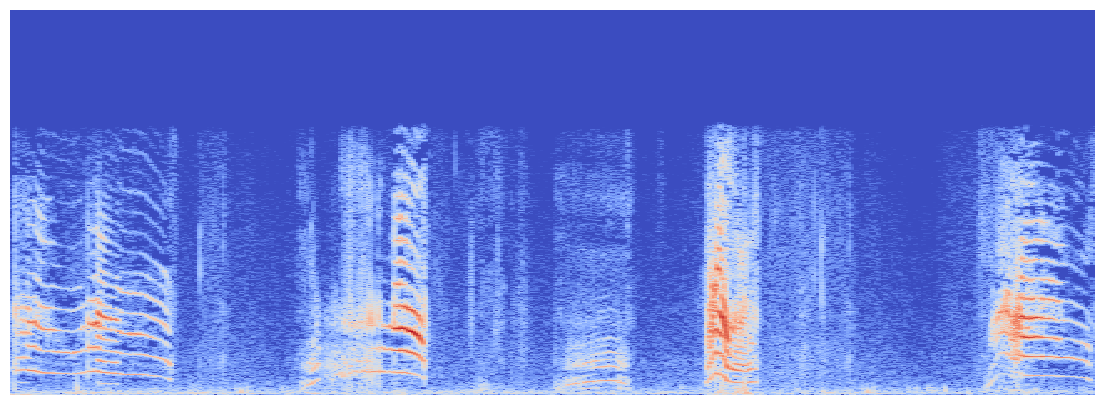

In [86]:
FILE_NAME = 'cat_143.wav'
SOURCE = '/kaggle/input/audio-cats-and-dogs/cats_dogs/test/cats/'
create_spectogram(FILE_NAME,SOURCE,'/kaggle/working/predict_test/')

In [88]:
Audio(SOURCE+FILE_NAME)

In [89]:
make_prediction('/kaggle/working/predict_test/cat_143.jpg')

1/1 [==============================] - 0s 23ms/step


array([[0.]], dtype=float32)